In [1]:
import numpy as np
import pandas as pd
import pickle

col_names = pd.read_csv('../data/dataset.csv', nrows=0).columns
dtype_map = {'class' : np.int16, 'bankruptcy_after_years' : np.int16}
dtype_map.update({col: np.float64 for col in col_names if col not in dtype_map})

df = pd.read_csv('../data/dataset.csv', dtype=dtype_map)
df = df.drop([df.columns[0], df.columns[1], df.columns[2], 'year'], axis=1)
df.drop_duplicates(keep=False, inplace=True)

df.head()

,Attr1,Attr2,Attr3,Attr4,Attr5,Attr6,Attr7,Attr8,Attr9,Attr10,...,Attr57,Attr58,Attr59,Attr60,Attr61,Attr62,Attr63,Attr64,class,bankruptcy_after_years
0,0.200550,0.37951,0.39641,2.0472,32.3510,0.38825,0.249760,1.33050,1.1389,0.50494,...,0.39718,0.87804,0.001924,8.4160,5.1372,82.658,4.4158,7.4277,0,0
1,0.209120,0.49988,0.47225,1.9447,14.7860,0.00000,0.258340,0.99601,1.6996,0.49788,...,0.42002,0.85300,0.000000,4.1486,3.2732,107.350,3.4000,60.9870,0,0
2,0.248660,0.69592,0.26713,1.5548,-1.1523,0.00000,0.309060,0.43695,1.3090,0.30408,...,0.81774,0.76599,0.694840,4.9909,3.9510,134.270,2.7185,5.2078,0,0
3,0.081483,0.30734,0.45879,2.4928,51.9520,0.14988,0.092704,1.86610,1.0571,0.57353,...,0.14207,0.94598,0.000000,4.5746,3.6147,86.435,4.2228,5.5497,0,0
4,0.187320,0.61323,0.22960,1.4063,-7.3128,0.18732,0.187320,0.63070,1.1559,0.38677,...,0.48431,0.86515,0.124440,6.3985,4.3158,127.210,2.8692,7.8980,0,0


XGBoost model and k-fold cross-validation, binary classification:

In [11]:
import xgboost
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score, cross_validate
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score
import numpy as np

scoring = {'accuracy' : make_scorer(accuracy_score),
           'precision' : make_scorer(precision_score, average='micro'),
           'recall' : make_scorer(recall_score, average='micro'), 
           'f1_score' : make_scorer(f1_score, average='micro')}

   
    
def save_model(model, frs, label, out_dir):
    model.fit(frs, label)
    pickle.dump(model, open(out_dir,'wb'))


def validate(out_dir, frs, label):  
    model = pickle.load(open(out_dir,'rb'))   
    kfold = KFold(n_splits=5)
    return cross_validate(estimator=model, X=frs, y=label, cv=kfold, scoring=scoring)

Fit and save  XGBoost classifier with all features (original data with missing values)

In [2]:
all_frs = df[df.columns.difference(['bankruptcy_after_years', 'class'])] # with NaNs
label = df['bankruptcy_after_years']
save_model(xgboost.XGBClassifier(), all_frs, label, '../models/xgboost.pkl')

Check cross-validation accuracy, precision, recall, and f1-score for XGBoost classifier fitted on all features with kept NaNs:

In [46]:
results = validate('../models/xgboost.pkl', all_frs, label)
results

{'fit_time': array([144.80531359, 139.43467355, 174.6276567 , 159.52204514,
        128.61141706]),
 'score_time': array([0.21106172, 0.2135067 , 0.25859308, 0.23638296, 0.17466044]),
 'test_accuracy': array([0.96819995, 0.95306266, 0.99941328, 0.94191504, 0.89238352]),
 'test_precision': array([0.96819995, 0.95306266, 0.99941328, 0.94191504, 0.89238352]),
 'test_recall': array([0.96819995, 0.95306266, 0.99941328, 0.94191504, 0.89238352]),
 'test_f1_score': array([0.96819995, 0.95306266, 0.99941328, 0.94191504, 0.89238352])}

In [47]:
np.mean(results['test_accuracy'])

0.9509948928308628

In [48]:
np.mean(results['test_precision'])

0.9509948928308628

In [49]:
np.mean(results['test_recall'])

0.9509948928308628

In [50]:
np.mean(results['test_f1_score'])

0.9509948928308628

- As it is seen from the 5-fold cross validation results, XGBoost classifier performs well on non-reduced and highly skewed imbalanced data - it means that further data reduction and / or imputation are redundant steps. The dataset chosen for analysis already contains synthetic features, so engineering new ones is not necessary in case of such a high performance.

In [3]:
model = pickle.load(open('../models/xgboost.pkl','rb'))

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f542e8b1390>,
      dtype=object)

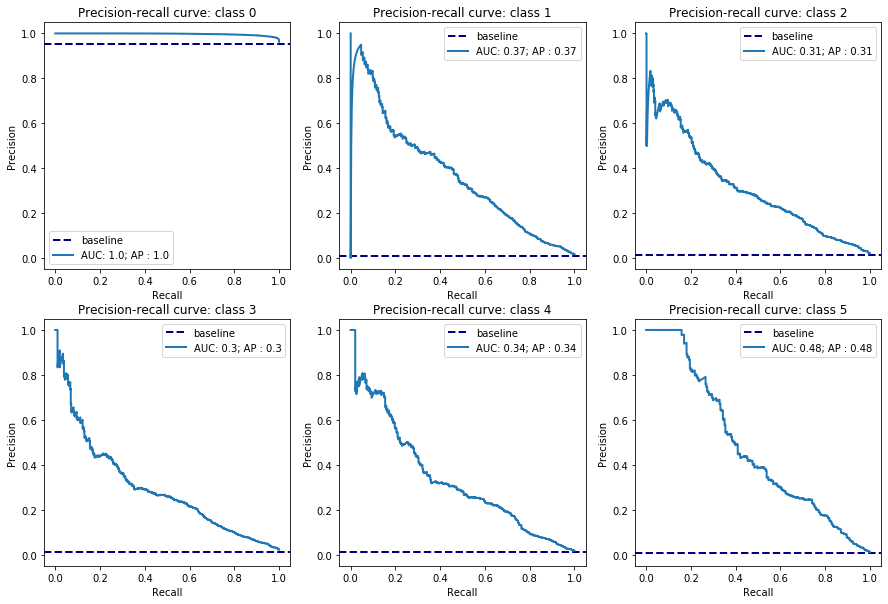

In [4]:
from sklearn.metrics import precision_recall_curve, auc, average_precision_score, roc_curve
import matplotlib.pyplot as plt

def plot_precision_recall(out_dir, y_test):
    model = pickle.load(open(out_dir,'rb'))  
    class_labels = np.sort(y_test.unique())

    row_count = np.ceil(len(class_labels) / 3).astype(int)
    fig, axes = plt.subplots(row_count, 3, figsize=(15, row_count*5))
    axes = axes.flatten()
    
    preds = model.predict_proba(all_frs)

    if len(axes) > len(class_labels):
        for i in range(len(class_labels), len(axes)):
            fig.delaxes(axes[i])

    for i, class_label in enumerate(class_labels):
        axes[i].axhline(sum(y_test == class_label)/len(y_test), color='navy', lw=2, linestyle='--', label='baseline')
        actuals = np.where(y_test == class_label, 1, 0)
        predicted_probabilities = preds[:,i]
        precision, recall, thresholds = precision_recall_curve(actuals, predicted_probabilities)
        auc_score = auc(recall, precision)
        ap_score = average_precision_score(actuals, predicted_probabilities)
        axes[i].plot(recall, precision, lw=2, label=f"""AUC: {auc_score:.2}; AP : {ap_score:.2}""")

        axes[i].legend()
        axes[i].set_title(f'Precision-recall curve: class {class_label}')
        axes[i].set_xlabel('Recall')
        axes[i].set_ylabel('Precision')

        axes[i].set_xlim(-0.05, 1.05)
        axes[i].set_ylim(-0.05, 1.05)

    return axes

    
plot_precision_recall('../models/xgboost.pkl', label)


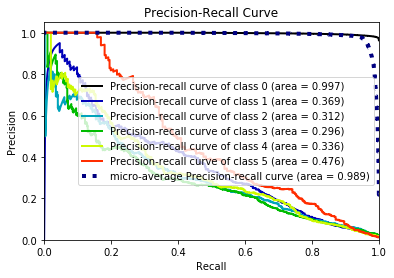

In [7]:
from scikitplot.plotters import plot_precision_recall_curve
import matplotlib.pyplot as plt

y_probas = model.predict_proba(all_frs)
plot_precision_recall_curve(label, y_probas)
plt.show()

As it is seen from the precision-recall curves above, the XGBoost classifier tends to classify non-bankrupted companies and still misclassify bankrupted companies due to the dataset strong skewness towards non-bankrupted class (class 0).

In [8]:
df['bankruptcy_after_years'].value_counts()

0    40534
2      511
3      491
1      406
4      396
5      271
Name: bankruptcy_after_years, dtype: int64

In [5]:
from sklearn.impute import SimpleImputer
import gc
import numpy as np

imp = SimpleImputer(missing_values=np.nan, strategy='mean')
imp_data = imp.fit_transform(df)
imp_data_df = pd.DataFrame(imp_data, index=df.index, columns=df.columns)

X = imp_data_df[imp_data_df.columns.difference(['bankruptcy_after_years', 'class'])]
Y = imp_data_df['bankruptcy_after_years']

del imp_data, imp_data_df
gc.collect()

0

In [7]:
from imblearn.over_sampling import SMOTE

sm = SMOTE(random_state=111)
X_res, y_res = sm.fit_resample(X, Y)
X_res.describe()

,Attr1,Attr10,Attr11,Attr12,Attr13,Attr14,Attr15,Attr16,Attr17,Attr18,...,Attr59,Attr6,Attr60,Attr61,Attr62,Attr63,Attr64,Attr7,Attr8,Attr9
count,243204.000000,243204.000000,243204.000000,243204.000000,243204.000000,243204.000000,2.432040e+05,243204.000000,243204.000000,243204.000000,...,243204.000000,243204.000000,2.432040e+05,243204.000000,2.432040e+05,243204.000000,243204.000000,243204.000000,243204.000000,243204.000000
mean,-0.163196,0.008960,-0.094943,-1.171724,0.230821,-0.145627,3.274770e+03,-0.739304,7.061750,-0.144720,...,0.640439,-0.601889,1.740681e+02,15.304702,9.588452e+02,7.874449,73.029088,-0.145629,5.971279,2.040852
std,5.900643,11.617880,6.152904,77.169012,37.819191,6.268849,5.440358e+04,75.631398,204.692970,6.272886,...,51.988400,11.691532,1.338958e+04,236.666543,6.070994e+04,60.884810,1958.380190,6.268849,204.064236,24.276353
min,-463.890000,-479.910000,-463.890000,-6331.800000,-1460.600000,-517.480000,-9.632400e+06,-6331.800000,-0.412920,-517.480000,...,-327.970000,-508.410000,-1.244000e+01,-12.656000,-2.336500e+06,-1.543200,-10677.000000,-517.480000,-141.410000,-3.496000
25%,-0.086511,0.150705,-0.062566,-0.164558,-0.038257,-0.086800,-1.092215e+03,-0.066542,1.237631,-0.086800,...,0.000000,-0.119621,6.385079e+00,5.139070,6.187600e+01,2.498099,2.810767,-0.086800,0.218298,1.011573
50%,0.011029,0.334289,0.033051,0.028392,0.027404,0.015137,7.881809e+02,0.076876,1.607207,0.015138,...,0.048011,0.000000,1.208901e+01,7.791260,1.007739e+02,3.952851,5.520893,0.015134,0.573466,1.319788
75%,0.072400,0.539869,0.113318,0.226749,0.076070,0.088266,3.056357e+03,0.277362,2.490038,0.088291,...,0.348991,0.006914,3.267962e+01,12.749856,1.627020e+02,6.615670,15.551344,0.088263,1.425114,2.210976
max,94.280000,1099.500000,681.540000,8259.400000,13315.000000,649.230000,1.023600e+07,8259.400000,53433.000000,649.230000,...,23853.000000,543.250000,4.818700e+06,108000.000000,2.501600e+07,23454.000000,294770.000000,649.230000,53432.000000,9742.300000


In [8]:
X_res.shape

(243204, 64)

In [9]:
df.shape

(42609, 66)

In [10]:
y_res.value_counts()

1.0    40534
5.0    40534
4.0    40534
3.0    40534
2.0    40534
0.0    40534
Name: bankruptcy_after_years, dtype: int64

In [12]:
save_model(xgboost.XGBClassifier(), X_res, y_res, '../models/xgboost_SMOTE.pkl')

In [13]:
results = validate('../models/xgboost_SMOTE.pkl', X_res, y_res)
np.mean(results['test_precision'])

0.09140476667331221

In [14]:
np.mean(results['test_recall'])

0.09140476667331221

/opt/conda/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_precision_recall_curve is deprecated; This will be removed in v0.4.0. Please use scikitplot.metrics.plot_precision_recall_curve instead.
  warnings.warn(msg, category=FutureWarning)


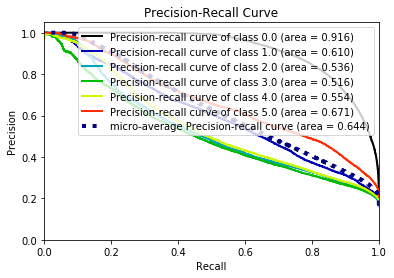

In [17]:
model = pickle.load(open('../models/xgboost_SMOTE.pkl','rb'))

y_probas = model.predict_proba(X_res)
plot_precision_recall_curve(y_res, y_probas)
plt.show()

SMOTE oversampling of dataset with imputed missing values has reduced the micro-average precision-recall area under the curve (all features kept).